In [ ]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt

##Data Loading

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
num_classes = 10

11501568/11490434 [==============================] - 0s 0us/step


## Function to Pre-process the data

In [ ]:
def preprocess(images, labels, placeholder=""):
  images = (images / 255)
  images = images.reshape((-1, 28, 28, 1))
  labels = tf.keras.utils.to_categorical(labels, num_classes)
  print("{} shape {}, {}".format(placeholder, images.shape, labels.shape))
  return images, labels

##Actual Model Configurations

In [ ]:
def model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

## Create and fit model

In [ ]:
model = model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 10, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 64)          0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                        

##Preprocessing the data

In [ ]:
x_train, y_train = preprocess(x_train, y_train, "Train Data")
x_test, y_test = preprocess(x_test, y_test, "Test Data")

Train Data shape (60000, 28, 28, 1), (60000, 10)
Test Data shape (10000, 28, 28, 1), (10000, 10)


##Model Training and Validation

In [ ]:
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          validation_data=(x_test, y_test))

Epoch 1/20
938/938 [==============================] - 14s 14ms/step - loss: 0.0227 - accuracy: 0.8403 - val_loss: 0.0067 - val_accuracy: 0.9538
Epoch 2/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0095 - accuracy: 0.9390 - val_loss: 0.0052 - val_accuracy: 0.9646
Epoch 3/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0077 - accuracy: 0.9501 - val_loss: 0.0041 - val_accuracy: 0.9723
Epoch 4/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0066 - accuracy: 0.9572 - val_loss: 0.0038 - val_accuracy: 0.9757
Epoch 5/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0060 - accuracy: 0.9617 - val_loss: 0.0037 - val_accuracy: 0.9760
Epoch 6/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0055 - accuracy: 0.9649 - val_loss: 0.0034 - val_accuracy: 0.9788
Epoch 7/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0052 - accuracy: 0.9669 - val_loss: 0.0036 - val_accuracy:

In [ ]:
# Assessing base model accuracy on regular images
print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Base accuracy on regular images: [0.0030037546530365944, 0.9811000227928162]


## Untargeted Attack(Fast gradient sign method)
###Function to create adversarial pattern by calculating gradient w.r.to input using tf.sign.

In [ ]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_gradient = tf.sign(gradient)
    
    return signed_gradient

##Targeted Attack

In [ ]:
def adversarial_target_pattern(image, label, target):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        originalLoss = tf.keras.losses.MSE(label, prediction)
        targetLoss = tf.keras.losses.MSE(target, prediction)
        totalLoss = originalLoss + targetLoss

    gradient = tape.gradient(totalLoss, image)
    
    signed_gradient = tf.sign(gradient)
    
    return signed_gradient


## Displaying single adversarial example

tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
Actual input image prediction - five
Adversarial input image prediction - three
Adversarial target input image prediction - five
(1, 28, 28, 1)
(1, 28, 28, 1)


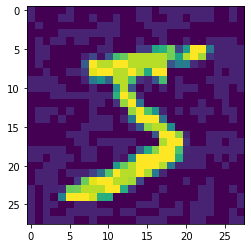

In [ ]:
image = x_train[0]
image_label = y_train[0]
target_class = tf.reshape(tf.one_hot(1, num_classes),[1, num_classes])
print(target_class)
perturbations = adversarial_pattern(image.reshape((1, 28, 28, 1)), 
                                    image_label).numpy()
perturbation_target = adversarial_target_pattern(image.reshape((1, 28, 28, 1)), 
                                    image_label, target_class).numpy()
adversarial = image + perturbations * 0.1 #small constant to perturbations
adversarial = tf.clip_by_value(adversarial, 0, 1.0)
adversarial_target = image - perturbation_target * 0.1 #small constant to perturbations
adversarial_target = tf.clip_by_value(adversarial_target, 0, 1.0)


print("Actual input image prediction - {}".format(
    labels[model.predict(image.reshape((1, 28, 28, 1))).argmax()]))
print("Adversarial input image prediction - {}".format(
    labels[model.predict(adversarial).argmax()]))
print("Adversarial target input image prediction - {}".format(
    labels[model.predict(adversarial_target).argmax()]))

plt.show()
#Display the adversarial image
print(adversarial.shape)
plt.imshow(adversarial.numpy().reshape((28, 28)))
print(adversarial_target.shape)
plt.imshow(adversarial_target.numpy().reshape((28, 28)))

plt.show()

## Adversarial data generator

In [ ]:
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, 28, 28, 1)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            adversarial = tf.clip_by_value(adversarial, 0, 1.0)
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, 28, 28, 1))
        y = np.asarray(y)
        
        yield x, y

Prediction Label: nine  Ground Truth: nine


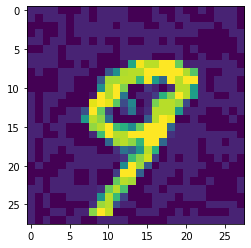

Prediction Label: zero  Ground Truth: five


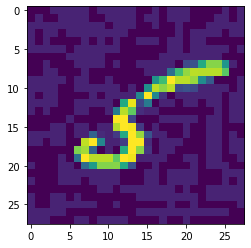

Prediction Label: five  Ground Truth: five


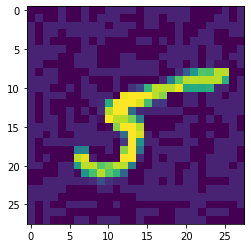

Prediction Label: seven  Ground Truth: nine


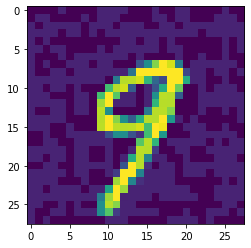

Prediction Label: nine  Ground Truth: five


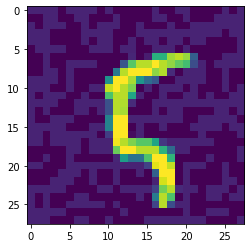

Prediction Label: nine  Ground Truth: nine


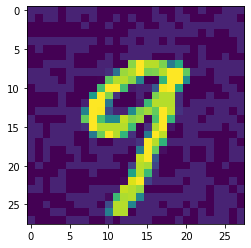

Prediction Label: three  Ground Truth: five


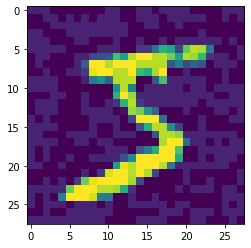

Prediction Label: seven  Ground Truth: nine


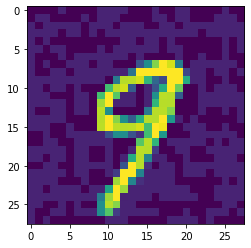

Prediction Label: eight  Ground Truth: eight


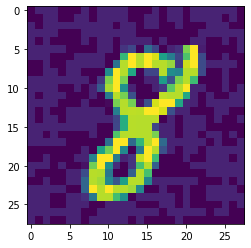

Prediction Label: three  Ground Truth: three


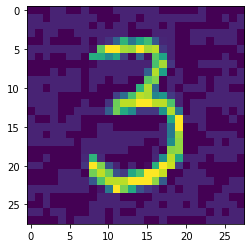

In [ ]:
# Generate and visualize 10 adversarial images
adversarials, correct_labels = next(generate_adversarials(10))
for adversarial, correct_label in zip(adversarials, correct_labels):
    print('Prediction Label:', 
          labels[model.predict(adversarial.reshape((1, 28, 28, 1))).argmax()], 
          ' Ground Truth:', labels[correct_label.argmax()])
    plt.imshow(adversarial.reshape(28, 28))
    plt.show()

## Adversarial data generation

In [ ]:
x_adversarial_train, y_adversarial_train = next(generate_adversarials(20000))
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))

In [ ]:
# Assess base model on adversarial data
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy on adversarial images: [0.04692775383591652, 0.722100019454956]


##Adversarial Training

In [ ]:
model.fit(x_adversarial_train, y_adversarial_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test))

Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 0.0017 - accuracy: 0.9895 - val_loss: 0.0075 - val_accuracy: 0.9544
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 1.3161e-04 - accuracy: 0.9991 - val_loss: 0.0068 - val_accuracy: 0.9599
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 1.3544e-04 - accuracy: 0.9990 - val_loss: 0.0083 - val_accuracy: 0.9510
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 6.8034e-05 - accuracy: 0.9995 - val_loss: 0.0080 - val_accuracy: 0.9538
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 6.9976e-05 - accuracy: 0.9995 - val_loss: 0.0075 - val_accuracy: 0.9560
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 5.8575e-05 - accuracy: 0.9997 - val_loss: 0.0099 - val_accuracy: 0.9448
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 4.3543e-05 - accuracy: 0.9998 - val_loss: 0.009

In [ ]:
# Assess defended model on adversarial data
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

# Assess defended model on regular data
print("Defended accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Defended accuracy on adversarial images: [2.2924897086600885e-17, 1.0]
Defended accuracy on regular images: [0.012051786296069622, 0.9333999752998352]


In [ ]:
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Defended accuracy on adversarial images: [0.0024837430100888014, 0.9882000088691711]


##Targeted adversarial generation

In [ ]:
def generate_adversarials_target(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)
            target_class = tf.reshape(tf.one_hot(1, num_classes),[1, num_classes])
            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_target_pattern(image.reshape((1, 28, 28, 1)), label, target_class).numpy()
            
            
            epsilon = 0.1
            adversarial = image - perturbations * epsilon
            adversarial = tf.clip_by_value(adversarial, 0, 1.0)
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, 28, 28, 1))
        y = np.asarray(y)
        
        yield x, y

Prediction Label: three  Ground Truth: three


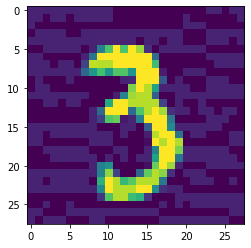

Prediction Label: nine  Ground Truth: nine


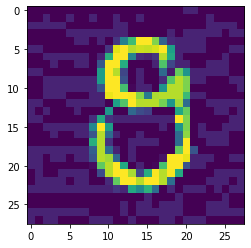

Prediction Label: seven  Ground Truth: seven


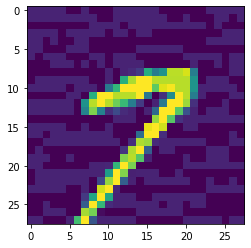

Prediction Label: three  Ground Truth: nine


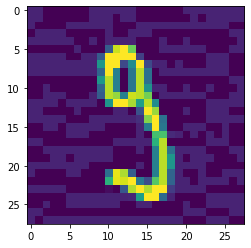

Prediction Label: eight  Ground Truth: eight


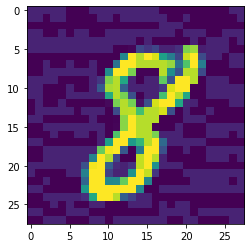

Prediction Label: eight  Ground Truth: eight


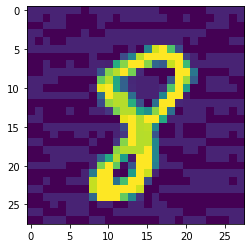

Prediction Label: three  Ground Truth: three


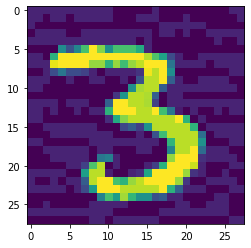

Prediction Label: two  Ground Truth: two


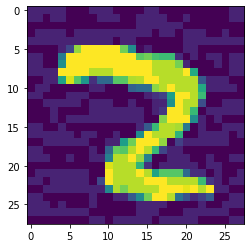

Prediction Label: three  Ground Truth: three


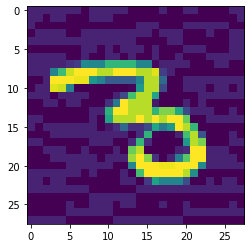

Prediction Label: three  Ground Truth: three


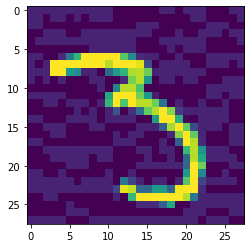

In [ ]:
# Generate and visualize 10 adversarial images
adversarials, correct_labels = next(generate_adversarials_target(10))
for adversarial_target, correct_label in zip(adversarials, correct_labels):
    print('Prediction Label:', 
          labels[model.predict(adversarial_target.reshape((1, 28, 28, 1))).argmax()], 
          ' Ground Truth:', labels[correct_label.argmax()])
    plt.imshow(adversarial_target.reshape(28, 28))
    plt.show()

In [ ]:
x_adversarial_target_train, y_adversarial_target_train = next(generate_adversarials_target(20000))
x_adversarial_target_test, y_adversarial_target_test = next(generate_adversarials_target(10000))

In [ ]:
# Assess base model on adversarial data
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_target_test, y=y_adversarial_target_test, verbose=0))

Base accuracy on adversarial images: [0.002128001069650054, 0.9882000088691711]


In [ ]:
model = model()
model.summary()
model.fit(x_adversarial_target_train, y_adversarial_target_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                      

In [ ]:
# Assess defended model on adversarial data
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_target_test, y=y_adversarial_target_test, verbose=0))

# Assess defended model on regular data
print("Defended accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))


Defended accuracy on adversarial images: [3.5690514091058195e-17, 1.0]
Defended accuracy on regular images: [0.05517040565609932, 0.692300021648407]


In [ ]:
x_adversarial_target_test, y_adversarial_target_test = next(generate_adversarials_target(10000))
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_target_test, y=y_adversarial_target_test, verbose=0))

Defended accuracy on adversarial images: [0.05564846843481064, 0.6726999878883362]
